# Bank-Note Authentication with logistic regression (70 points)

In this question, we will use the logistic regression method to train a model that distinguishes between genuine and forged banknote images. The dataset that we employ consists of four features extracted from digitized banknotes. So, instead of processing images, we use these features to perform our classification.

Now, we begin with preparing our data.

## Imports

Feel free to import any library you need.

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

## Data preparation (4 points)

Here, we load the "Bank Note Authentication UCI data" dataset, containing 1372 samples with four extracted features, and the binary column named "class" showing whether the sampled data is genuine or forged. Run and complete the bellow cells to get familiar with the data and prepare it for the training phase. 

In [2]:
banknote_df = pd.read_csv('BankNote_Authentication.csv')
banknote_df

variance  skewness  curtosis  entropy  class
0      3.62160   8.66610   -2.8073 -0.44699      0
1      4.54590   8.16740   -2.4586 -1.46210      0
2      3.86600  -2.63830    1.9242  0.10645      0
3      3.45660   9.52280   -4.0112 -3.59440      0
4      0.32924  -4.45520    4.5718 -0.98880      0
...        ...       ...       ...      ...    ...
1367   0.40614   1.34920   -1.4501 -0.55949      1
1368  -1.38870  -4.87730    6.4774  0.34179      1
1369  -3.75030 -13.45860   17.5932 -2.77710      1
1370  -3.56370  -8.38270   12.3930 -1.28230      1
1371  -2.54190  -0.65804    2.6842  1.19520      1

[1372 rows x 5 columns]

In [3]:
features_list = banknote_df.columns.tolist()
features_list.remove("class")
print(features_list)

X = np.array(banknote_df[features_list].values)
Y = np.array(banknote_df["class"].values)

['variance', 'skewness', 'curtosis', 'entropy']


After preparing X and Y arrays, we should split them into train and test sets. Also, we standardize X values to improve the performance of logistic regression.

To standardize the data, we use the below formula and apply it to every column of X:

\begin{equation}
X_{standard} = \frac{X - \mu}{\sigma}
\end{equation}

where $\mu$ is mean and $\sigma$ is standard deviation of data.

Now, use the provided formula and complete the "standardize" function. Then, split X and Y into train and test sets and standardize them. Note that you have to standardize the X_train and X_test set separately.

In [4]:
def standardize(data_numpy):
    # Gets a numpy ndarray and standardizes it along axis=0
    # ----------------------- To do: (2 points)
    normalized_data = (data_numpy - np.mean(data_numpy, axis=0)) / np.std(data_numpy, axis=0)
    # -----------------------
    return normalized_data

In [5]:
total_count = X.shape[0]
train_count = int(0.8 * total_count)
test_count = total_count - train_count

# ----------------------- To do: (2 points)
X_train = standardize(X[0:train_count])
Y_train = Y[0:train_count]
print(f"X_train's shape: {X_train.shape}")

X_test = standardize(X[train_count:])
Y_test = Y[train_count:]
print(f"X_test's shape: {X_test.shape}")
# -----------------------

X_train's shape: (1097, 4)
X_test's shape: (275, 4)


## Implementing Logistic Regression (16 points)

Now that the data is ready, we can implement the logistic regression method which is quite simple. All we need here is a sigmoid function as the probability function, a loss function, and a function that performs gradient descent for updating weights. The only thing that needs to be pointed out is that we use the whole train data in each iteration to update the weights. Hence, you need to use matrix operations provided by numpy to implement these functions.

Let's start with sigmoid. Complete the sigmoid function that gets 2D array X, and weights array W as inputs and calculates the probability for every row in X:

In [6]:
def sigmoid(X, W):
    # Gets X and W numpy arrays and calculate the sigmoid function
    # X's shape: (num_data * num_features)
    # W's shape: (num_features)
    # output's shape: (num_data)

    # ----------------------- To do: (2 points)
    out = np.dot(X, W)
    out = 1 / (1 + np.exp(-out))
    # -----------------------
    return out

After that, we need a loss function which is "log loss" here. In this function, we have a log loss term with an additional l2 regularization term that can be formulated over m input data as below:

\begin{equation}
Loss = -\frac{1}{m}\sum{(Y_i\times ln(H(X_i)) + (1-Y_i)\times ln(1-H(X_i)))} + \frac{\lambda}{2m}|W|^2
\end{equation}

where H is sigmoid's output.

In [7]:
def log_loss(Y, H, W, lambda_reg):
    # Gets Y (ground truth), H (predicted), W (weights vector), and regularization lambda
    # Then computes the "log loss" 

    # ----------------------- To do: (7 points)
    loss = -(Y * np.log(H) + (1 - Y) * np.log(1 - H)) + lambda_reg * np.dot(W, W) / 2
    loss = loss.mean()
    # -----------------------
    return loss

In the end, we need a function that performs gradient descent and updates the weights vector. For this purpose, we use the formulated derivative of the loss function to calculate the gradient:

\begin{equation}
\frac{\partial Loss}{\partial W} = \frac{1}{m}\sum{((H(X_i) - Y_i)X_i)} + \frac{\lambda}{m}W
\end{equation}

Use this formula to complete the gradient function. Then, implement the gradient descent function using the gradient function.

In [8]:
def gradient(X, Y, H, W, lambda_reg):
    # Gets X (data), Y (ground truth), H (predicted), W (weights vector), and regularization lambda
    # Then calculates the gradient vector
    
    # ----------------------- To do: (5 points)
    grad = (np.dot(X.T, H - Y) + lambda_reg * W) / Y.shape[0]
    # -----------------------
    return grad

def gradient_descent(X, Y, H, W, alpha, lambda_reg):
    # Performs gradient descent and returns updated weights
    # W_new = W_old - alpha * grad

    # ----------------------- To do: (2 points)
    W_new = W - alpha * gradient(X, Y, H, W, lambda_reg)
    # -----------------------
    return W_new

# Training and Evaluation without Regularization (23 points)

In this section, we will train logistic regression models with different learning rates and the number of iterations. Also, we set the value of lambda to zero and remove the regularization term. Then, we plot training loss and accuracy on both the train and test sets for every setting and compare them. But, before we go through training, we need to add an extra column to X_train and X_test for the bias feature.

In [9]:
X_train = np.concatenate((X_train, np.ones((X_train.shape[0], 1), dtype=float)), axis=1)
X_test = np.concatenate((X_test, np.ones((X_test.shape[0], 1), dtype=float)), axis=1)

Now, complete the below cell to train a logistic regression model for every pair in the nem_iters and lrs lists, and keep the weights vector and list of training loss for every setting in the training_rsults dictionary for visualization and evaluation steps.

Warning: Running the below cell might take up to 10 minutes. :)

In [10]:
start = time.time()
num_iters = [1e3, 1e4, 1e5, 1e6]
lrs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]

training_results = {}

for lr_idx, lr in enumerate(lrs):
    for num_iter_idx, num_iter in enumerate(num_iters):
        # ----------------------- To do: (10 points)
        loss_list = []
        W = np.zeros(X_train.shape[1])
        for i in range(int(num_iter)):
            H = sigmoid(X_train, W)
            loss = log_loss(Y_train, H, W, 0.0)
            loss_list.append(loss)
            W = gradient_descent(X_train, Y_train, H, W, lr, 0.0)
        training_results[(lr_idx, num_iter_idx)] = [W, np.array(loss_list)]
        # ----------------------- 

end = time.time()
print(f"Training time: {round((end - start) / 60, 2)} minutes")

Training time: 7.71 minutes


Complete the below cell and visualize the training losses over iterations.

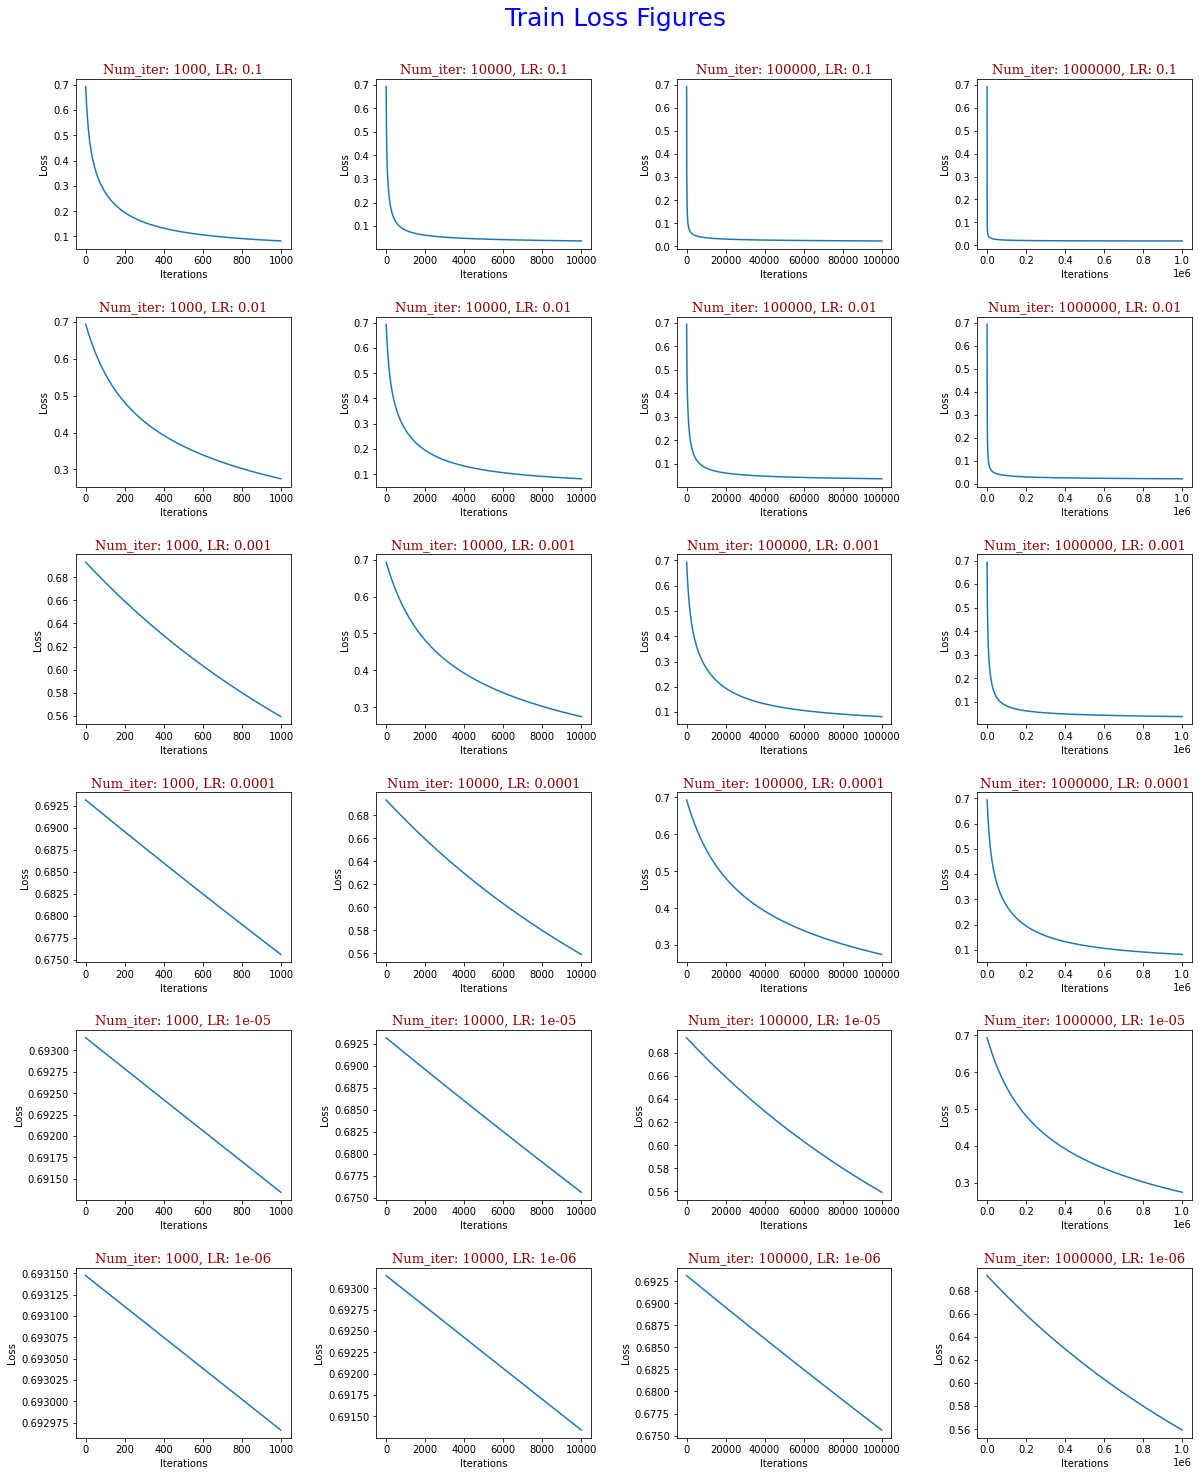

In [11]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':13}

fig, axs = plt.subplots(len(lrs), len(num_iters), figsize=(20, 25))

fig.suptitle('Train Loss Figures', fontsize=25, color='blue', y=0.92)

fig.subplots_adjust(hspace=0.4, wspace=0.4)

lrs = np.array(lrs)

for num_iter_idx, num_iter in enumerate(num_iters):
    for lr_idx, lr in enumerate(lrs):
        # ----------------------- To do: (1 point)
        axs[lr_idx][num_iter_idx].plot(np.arange(training_results[(lr_idx, num_iter_idx)][1].shape[0])
                                       , training_results[(lr_idx, num_iter_idx)][1])
        # -----------------------
        axs[lr_idx][num_iter_idx].set_title(f'Num_iter: {int(num_iter)}, LR: {lr}', font2)
        axs[lr_idx][num_iter_idx].set(xlabel='Iterations', ylabel=f'Loss')


Complete the below cells to calculate train and test set accuracy, then visualize them.

In [12]:
test_accuracies = {}
train_accuracies = {}


for num_iter_idx, num_iter in enumerate(num_iters):
    test_results = []
    train_results = []
    for lr_idx, lr in enumerate(lrs):
        # ----------------------- To do: (5 points)
        test_result = sigmoid(X_test, training_results[(lr_idx, num_iter_idx)][0])
        test_result = np.array([1 if x > 0.5 else 0 for x in test_result])
        accuracy_test = np.sum(test_result == Y_test) / test_result.shape[0] * 100
        test_results.append(accuracy_test)

        train_result = sigmoid(X_train, training_results[(lr_idx, num_iter_idx)][0])
        train_result = np.array([1 if x > 0.5 else 0 for x in train_result])
        accuracy_train = np.sum(train_result == Y_train) / train_result.shape[0] * 100
        train_results.append(accuracy_train)
        # -----------------------
    
    # ----------------------- To do:
    test_accuracies[num_iter_idx] = test_results
    train_accuracies[num_iter_idx] = train_results
    # -----------------------


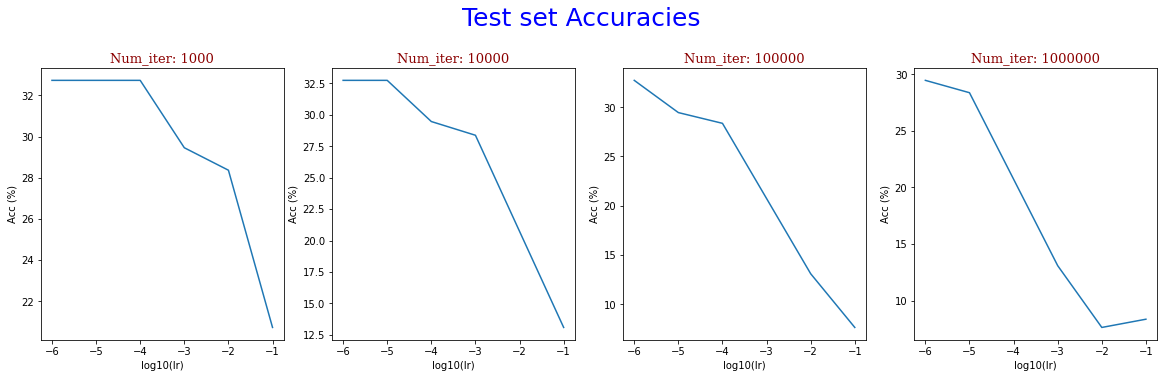

In [13]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':13}

fig, axs = plt.subplots(1, len(num_iters), figsize=(20, 5))

fig.suptitle('Test set Accuracies', fontsize=25, color='blue', y=1.05)

lrs = np.array(lrs)

for num_iter_idx, num_iter in enumerate(num_iters):
    # ----------------------- To do: (1 point)
    axs[num_iter_idx].plot(np.log10(lrs), test_accuracies[num_iter_idx])
    # -----------------------
    axs[num_iter_idx].set_title(f'Num_iter: {int(num_iter)}', font2)

for ax in axs.flat:
    ax.set(xlabel='log10(lr)', ylabel='Acc (%)')


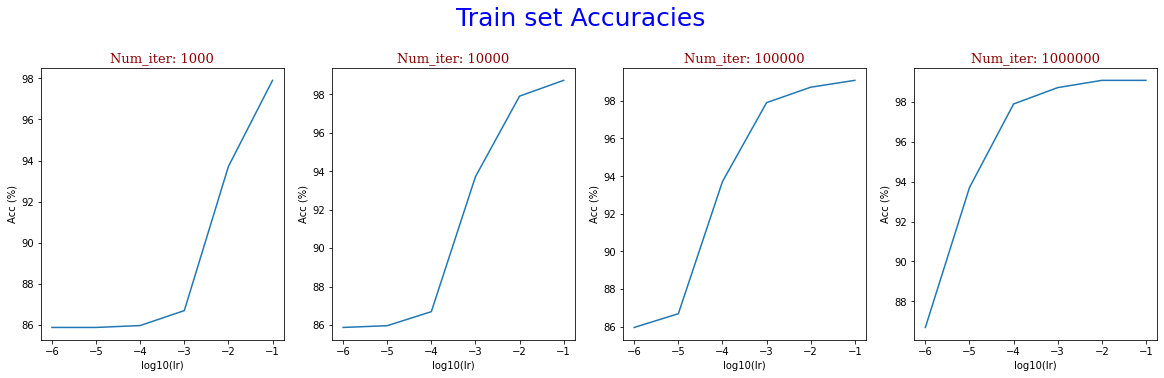

In [14]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':13}

fig, axs = plt.subplots(1, len(num_iters), figsize=(20, 5))

fig.suptitle('Train set Accuracies', fontsize=25, color='blue', y=1.05)

lrs = np.array(lrs)

for num_iter_idx, num_iter in enumerate(num_iters):
    # ----------------------- To do: (1 point)
    axs[num_iter_idx].plot(np.log10(lrs), train_accuracies[num_iter_idx])
    # -----------------------
    axs[num_iter_idx].set_title(f'Num_iter: {int(num_iter)}', font2)

for ax in axs.flat:
    ax.set(xlabel='log10(lr)', ylabel='Acc (%)')


Now, take a look at these plotted loss and accuracy figures. Which learning rates and num_iters are appropriate for this problem? Briefly explain your opinion in one paragraph. (This part has an extra point.) (5 points)

Your answer: 
- pointing out 1 or 2 suitable learning rate values
- pointing out 1 or 2 suitable num_iter values
- pointing out the test accuracy decline and overfitting

# Training and Evaluation with Regularization (17 points)

In this section, we have the same approach as the last section. But, instead of having variable num_iters, we fix this parameter and use several regularization lambdas to investigate its effect on final results.

Complete the below cell to train a logistic regression model for every pair in the reg_lambdas and lrs lists, and keep the weights vector and list of training loss for every setting in the training_results_reg dictionary for visualization and evaluation steps.

Warning: Running the below cell might take up to 2 minutes. :)

In [15]:

start = time.time()

lrs = [1e-1, 1e-2, 1e-3]
reg_lambdas = [2.0, 1.0, 1e-1, 1e-2]
num_iter = 1e5

training_results_reg = {}

for lr_idx, lr in enumerate(lrs):
    for reg_lambda_idx, reg_lambda in enumerate(reg_lambdas):
        # ----------------------- To do: (6 points)
        loss_list = []
        W = np.zeros(X_train.shape[1])
        for i in range(int(num_iter)):
            H = sigmoid(X_train, W)
            loss = log_loss(Y_train, H, W, reg_lambda)
            loss_list.append(loss)
            W = gradient_descent(X_train, Y_train, H, W, lr, reg_lambda)
        training_results_reg[(lr_idx, reg_lambda_idx)] = [W, np.array(loss_list)]
        # -----------------------

end = time.time()
print(f"Training Time: {round((end - start) / 60, 2)} minutes")

Training Time: 1.32 minutes


Complete the below cell and visualize the training losses over iterations.

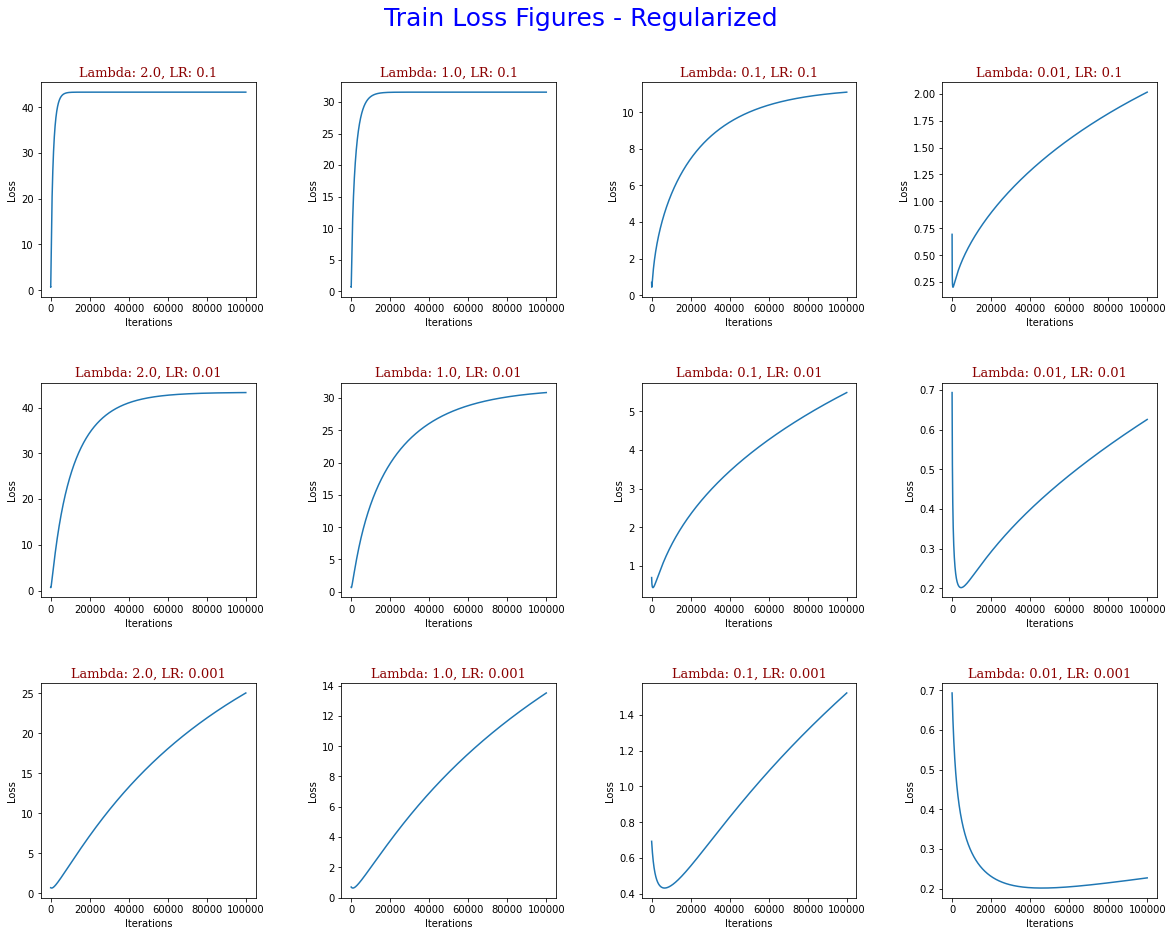

In [16]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':13}

fig, axs = plt.subplots(len(lrs), len(reg_lambdas), figsize=(20, 15))

fig.suptitle('Train Loss Figures - Regularized', fontsize=25, color='blue', y=0.95)

fig.subplots_adjust(hspace=0.4, wspace=0.4)

lrs = np.array(lrs)

for reg_lambda_idx, reg_lambda in enumerate(reg_lambdas):
    for lr_idx, lr in enumerate(lrs):
        # ----------------------- To do: (1 point)
        axs[lr_idx][reg_lambda_idx].plot(np.arange(training_results_reg[(lr_idx, reg_lambda_idx)][1].shape[0])
                                       , training_results_reg[(lr_idx, reg_lambda_idx)][1])
        # -----------------------
        axs[lr_idx][reg_lambda_idx].set_title(f'Lambda: {reg_lambda}, LR: {lr}', font2)
        axs[lr_idx][reg_lambda_idx].set(xlabel='Iterations', ylabel=f'Loss')


Complete the below cells to calculate train and test set accuracy, then visualize them.

In [17]:
test_accuracies_reg = {}
train_accuracies_reg = {}


for lambda_reg_idx, reg_lambda in enumerate(reg_lambdas):
    test_results = []
    train_results = []
    for lr_idx, lr in enumerate(lrs):
        # ----------------------- To do: (3 points)
        test_result = sigmoid(X_test, training_results_reg[(lr_idx, lambda_reg_idx)][0])
        test_result = np.array([1 if x > 0.5 else 0 for x in test_result])
        accuracy_test = np.sum(test_result == Y_test) / test_result.shape[0] * 100
        test_results.append(accuracy_test)

        train_result = sigmoid(X_train, training_results_reg[(lr_idx, lambda_reg_idx)][0])
        train_result = np.array([1 if x > 0.5 else 0 for x in train_result])
        accuracy_train = np.sum(train_result == Y_train) / train_result.shape[0] * 100
        train_results.append(accuracy_train)
        # -----------------------
        
    # ----------------------- To do:
    test_accuracies_reg[lambda_reg_idx] = test_results
    train_accuracies_reg[lambda_reg_idx] = train_results
    # -----------------------


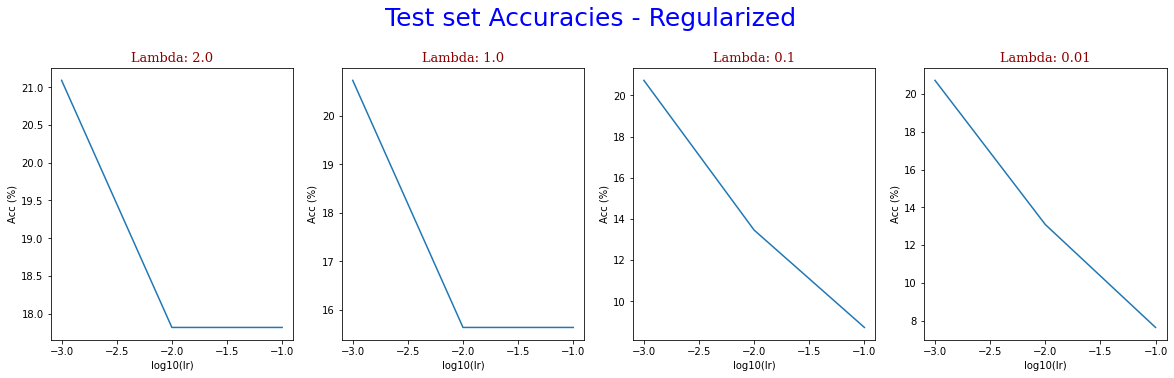

In [18]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':13}

fig, axs = plt.subplots(1, len(reg_lambdas), figsize=(20, 5))

fig.suptitle('Test set Accuracies - Regularized', fontsize=25, color='blue', y=1.05)

lrs = np.array(lrs)

for reg_lambda_idx, reg_lambda in enumerate(reg_lambdas):
    # ----------------------- To do: (1 point)
    axs[reg_lambda_idx].plot(np.log10(lrs), test_accuracies_reg[reg_lambda_idx])
    # -----------------------
    axs[reg_lambda_idx].set_title(f'Lambda: {reg_lambda}', font2)

for ax in axs.flat:
    ax.set(xlabel='log10(lr)', ylabel='Acc (%)')

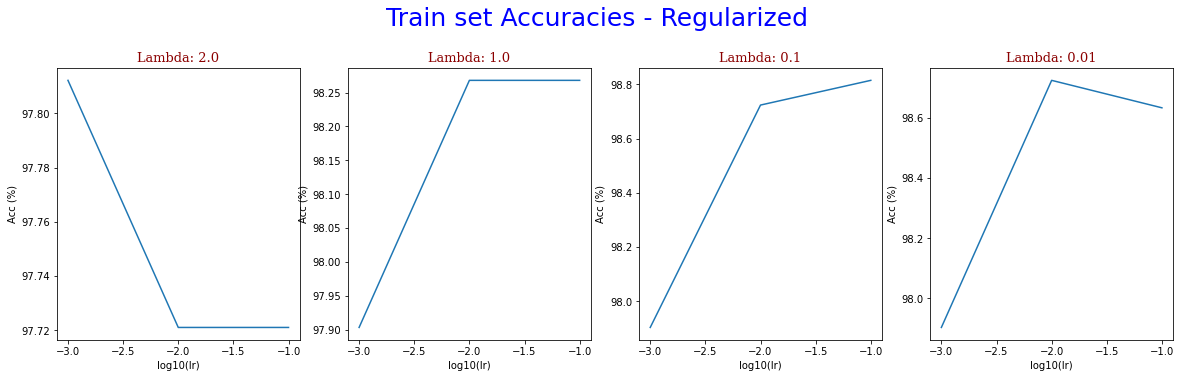

In [19]:
font1 = {'family':'serif','color':'blue','size':20}
font2 = {'family':'serif','color':'darkred','size':13}

fig, axs = plt.subplots(1, len(reg_lambdas), figsize=(20, 5))

fig.suptitle('Train set Accuracies - Regularized', fontsize=25, color='blue', y=1.05)

lrs = np.array(lrs)

for reg_lambda_idx, reg_lambda in enumerate(reg_lambdas):
    # ----------------------- To do: (1 point)
    axs[reg_lambda_idx].plot(np.log10(lrs), train_accuracies_reg[reg_lambda_idx])
    # -----------------------
    axs[reg_lambda_idx].set_title(f'Lambda: {reg_lambda}', font2)

for ax in axs.flat:
    ax.set(xlabel='log10(lr)', ylabel='Acc (%)')

Now, take a look at these plotted loss and accuracy figures. Has the regularization term had any effect on the overfitting of the model? Briefly explain your opinion in one paragraph. (5 points)

Your answer:
- pointing out that the bigger lambdas have a little bit prevented the overfitting
- pointing out that very small lambdas have no effects

## Using "sklearn" Library to Compare Results (10 points)

As our final move, we want to compare our results with the sklearn library. So, use the LogisticRegression() of the sklearn, fit a model, and print the train and test accuracies.

Hint: You have to create X_train and X_test again. The sklearn LogisticRegression() automatically adds bias values and standardizes the data.

In [20]:
clf = LogisticRegression()
# ----------------------- To do: (2 points)
X_train = X[0:train_count]
X_test = X[train_count:]
clf.fit(X_train, Y_train)
# -----------------------
print(f"intercept: {clf.intercept_}")
print(f"coefficient: {clf.coef_}")

intercept: [3.30352105]
coefficient: [[-3.21847752e+00 -1.75646885e+00 -2.15995421e+00  3.22256345e-04]]


In [21]:
# Perform the evaluation on train and test sets, and print the results.
# You can use sklearn.metrics.accuracy_score
# ----------------------- To do: (4 points)
y_pred_test = clf.predict(X_test)
y_pred_test = np.array(list(map(int, y_pred_test > 0.5)))

y_pred_train = clf.predict(X_train)
y_pred_train = np.array(list(map(int, y_pred_train > 0.5)))

test_acc = accuracy_score(Y_test, y_pred_test) * 100
print("Test Accuracy - sklearn: {:.4f}".format(test_acc))

train_acc = accuracy_score(Y_train, y_pred_train) * 100
print("Train Accuracy - sklearn: {:.4f}".format(train_acc))
# -----------------------


Test Accuracy - sklearn: 99.2727
Train Accuracy - sklearn: 98.8149


Now, take a look at these numbers. What did we do wrong in our implementation? Explain your idea. (This part has extra points.) (4 points)

Your answer:
- pointing out that our implementation here was very simple
- pointing out that libraries like sklearn use advanced  methods to improve implemented algorithms